In [3]:
import os

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import timm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from src.model import NW_CNN
from src.dataset import CropsPytorchDataset
from src.utils import Averager

In [4]:
torch.manual_seed(42)
le = LabelEncoder()
le.fit(['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-hold-motorcycle'])
train_dataset = CropsPytorchDataset(img_dir='data/annotated_data/clips/', anno_file='data_anno/training_data.csv', label_encoder=le, weights=True)
val_dataset = CropsPytorchDataset(img_dir='data/annotated_data/clips/', anno_file='data_anno/testing_data.csv', label_encoder=le, weights=True)

train_dataloader = DataLoader(train_dataset, batch_size=40, sampler=train_dataset.weighted_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=40, sampler=val_dataset.weighted_sampler)

In [3]:
out_dir = 'products/models'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [4]:
model = timm.create_model('resnet50', num_classes = 5, in_chans=1)
# model = NW_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

device = torch.device('cuda')
model.train()
model.to(device);

In [5]:
#In case you want to continue training from checkpoint
# model = torch.load('products/models/NW_CNN_checkpoint.pth')
# model.train()
# model.to(device)

In [ ]:
train_losses = []
val_losses = []
train_loss_hist = Averager()
val_loss_hist = Averager()
best_valid_loss=float('inf')
max_epochs = 30

for epoch in range(max_epochs):  # loop over the dataset multiple times
    print(f"\nEPOCH {epoch} of {max_epochs}")
    train_loss_hist.reset()
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)
    for inputs, labels in prog_bar:
        labels = torch.squeeze(labels, dim=1).long().to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss_hist.send(loss)
        loss.backward()
        optimizer.step()

   
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    train_losses.append(train_loss_hist.value)

    val_loss_hist.reset()  
    
    prog_bar = tqdm(val_dataloader, total=len(val_dataloader), leave=True)
    for inputs, labels in prog_bar:
        labels = torch.squeeze(labels, dim=1).long().to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        with torch.no_grad():
            loss = criterion(outputs, labels)
        val_loss_hist.send(loss)      
     
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    val_losses.append(val_loss_hist.value)

    #Saving best model
    if val_loss_hist.value < best_valid_loss:
        best_valid_loss = val_loss_hist.value
        print(f"\nBest validation loss: {best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch}\n")
        torch.save(model, os.path.join('products/models', f'weighted_resnet50_checkpoint.pth'))

    
print('Finished Training')

In [13]:
#logging losses
train_losses_np = [train_loss.detach().cpu().numpy().item() for train_loss in train_losses]
val_losses_np = [val_loss.detach().cpu().numpy().item() for val_loss in val_losses]
with open(os.path.join(out_dir, 'weighted_resnet50_train_loss.txt'), 'w') as f:
    for item in train_losses_np:
        f.write("%s\n" % item)

with open(os.path.join(out_dir, 'weighted_resnet50_val_loss.txt'), 'w') as f:
    for item in val_losses_np:
        f.write("%s\n" % item)

Testing

In [26]:
#Manually load the model to be tested
model = torch.load('products/models/NW_CNN_checkpoint.pth')
device = torch.device('cuda')
model.to(device)
model.eval();

In [27]:
#Extract testing results to be used with sklearn metrics
import time
import numpy as np

test_dataset = CropsPytorchDataset(img_dir='data/annotated_data/clips/', anno_file='data_anno/testing_data.csv', label_encoder=le, find_pairs=True, weights=False)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False)

start = time.time()
targets = []
predictions = []

prog_bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)
for input, label in prog_bar:
    input = input.to(device)
    prediction = torch.argmax(model(input), dim=1)
    label = torch.squeeze(label)

    predictions = np.concatenate((predictions, prediction.detach().cpu().numpy()))
    targets = np.concatenate((targets, label.detach().cpu().numpy()))
end = time.time();

100%|██████████| 192/192 [00:17<00:00, 11.05it/s]


Inference processing time on gpu: 17.38s
Accuracy score: 0.34

Precision scores: [0.66 0.   0.27 0.   0.41]
Macro precision: 0.27

Recall scores: [0.6  0.   0.99 0.   0.13]
Macro recall: 0.34

F1 scores: [0.63 0.   0.42 0.   0.19]
Macro F1: 0.25


c:\Users\vismi\Documents\University\7th Semester\Semester Project\ce7_741_HOI_detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vismi\Documents\University\7th Semester\Semester Project\ce7_741_HOI_detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


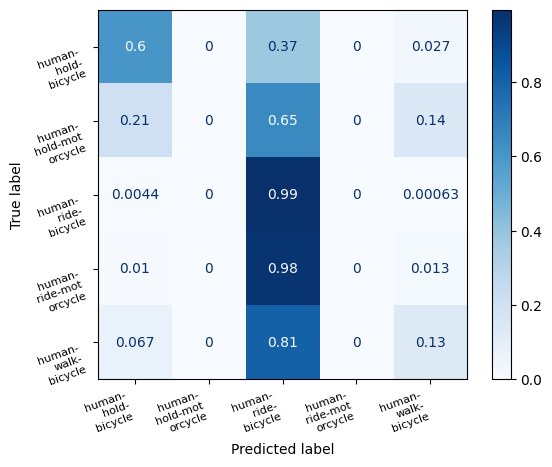

In [28]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from textwrap import wrap

print(f'Inference processing time on gpu: {round(end-start, 2)}s')
print(f'Accuracy score: {round(accuracy_score(targets, predictions), 2)}')
print(f'\nPrecision scores: {precision_score(targets, predictions, average=None).round(2)}')
print(f"Macro precision: {precision_score(targets, predictions, average='macro').round(2)}")

print(f'\nRecall scores: {recall_score(targets, predictions, average=None).round(2)}')
print(f"Macro recall: {recall_score(targets, predictions, average='macro').round(2)}")

print(f'\nF1 scores: {f1_score(targets, predictions, average=None).round(2)}')
print(f"Macro F1: {f1_score(targets, predictions, average='macro').round(2)}")


cm = confusion_matrix(targets, predictions, normalize='true')
labels = le.inverse_transform([0, 1, 2, 3, 4])
labels = labels = [ '\n'.join(wrap(l, 8)) for l in labels ]
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.yticks(rotation=20, va='top', fontsize=8)
plt.xticks(rotation=20, ha='right', fontsize=8)
plt.show()

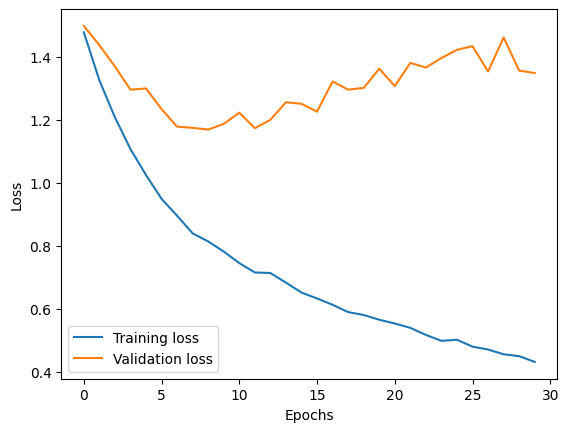

In [29]:
with open('products/models/weighted_resnet50_train_loss.txt', 'r') as f:
    data =  f.read()
    train_plot = data.split('\n')
    train_plot = [float(loss) for loss in train_plot]

with open('products/models/weighted_resnet50_val_loss.txt', 'r') as f:
    data =  f.read()
    val_plot = data.split('\n')
    val_plot = [float(loss) for loss in val_plot]

plt.plot(range(30), train_plot, label='Training loss')
plt.plot(range(30), val_plot, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
